In [1]:
!pip install --user emcee


In [16]:
import numpy as np
import numpy
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import scipy.misc as smp
import scipy.optimize as op
from mpl_toolkits import mplot3d
from scipy.integrate import odeint
from PIL import ImageFont
from PIL import ImageDraw
import random
import warnings
warnings.filterwarnings("ignore")

#importing raytracer function
from raytracer_optimized import raytracer

"""implement MCMC to raytracer
we want to loop over all pixels to get a large number
of data points
model is unnoisy image
observed data is noisy image
likelihood function can be a fitted gaussian distribution
so we have model - observed / error
we do this for each pixel
e.g. say observed is black (=0) and model is black (=0)
there is no difference """

"""
assign black pixels (0,0,0) is 0
and everything else as 1
now array is of form 200x200x1
note can flatten it from 200x200 array to 200x200 1d row
likelihood is fine otherwise though atm
then need to loop over every image and do this for every image
"""




truespin = 0.7
pixdensity = 8
trueview = np.pi/4
sigma = 0.1 #define sigma for likelihood
#var = sigma**2




#function to add noise to image, this is now the observed data
def noisy(noise_typ,image,sigma):
    if noise_typ == "gauss":
        row = image.shape #for shape (10,10,3) need row,col,ch respectively to be defined
        print(row)
        mean = 0
        gauss = np.random.normal(mean,sigma,(row))
        gauss = gauss.reshape(row)
        noisy = image + gauss #add pos and neg error
        #print(gauss)
        return noisy, gauss


#creates observed data from 0.9 spin image
fornoise = raytracer(trueview, truespin, pixdensity)    #returns binary flat array of image(model) #Image.open("/Users/hannahriley/Desktop/raytracerpngs/spin0.9.png")
print(fornoise)
#fornoisearray = np.asarray(fornoise) #this isnt needed for raytracer func call as already in array form
#noisearray = np.empty([pixdensity**2]) #for 2D change back to [pixdensity,pixdensity]
#counter=0
#counter2=0
#for i in range(len(fornoise)): #reshapes from 10,10,3 to 10,10 (ie sums the 3)
    #counter2+=1
    #for j in range(len(fornoisearray[i,:])):
        #counter+=1
    #noisearray[i]=np.sum(fornoise[i]) #to return to 2d would need index [i,j]
#binfor = (noisearray!=0).astype(int) #already done in raytracer function
obsarray, gauss = noisy("gauss",fornoise,sigma) #was binfor originally
print("obs data:\n",obsarray)
print("inv_sigma2",1/gauss**2)

#obsarr_im = np.reshape(obsarray, [pixdensity,pixdensity])
#obsim = smp.toimage(obsarr_im)
#obsim.show()
#obsarray.flatten()

#define likelihood function
def lnlike(theta, obs, pixdensity, gauss):
    view, spin = theta
    model = raytracer(view, spin, pixdensity)
    lnlike = 0
    inv_sigma2 = 1.0/(gauss**2) #from noisy function, sigma is sqrt(var)
    diff = obs - model
    #print("diff\n", diff)
    lnlike = -0.5* np.sum(diff*diff * inv_sigma2)
    return lnlike

#       MUST FIX!!!!
# nll = lambda * args : -lnlike(*args)
# result = op.minimize(nll, truespin, args=(obsarray, pixdensity, sigma)) #function, initial guesses, additional fixed arguments passed to objective (nll) function
# spinml = result["x"]

def lnprior(theta):            #log prior
    view, spin = theta
    if 0 < view < np.pi/2 - 0.1 and 0.0 < spin < 0.999:
        return 0.0
    return -np.inf

#combine with lnlike from above to get full log probability function
def lnprob(theta, obs, pixdensity, sigma):
    lp = lnprior(theta)
    if not np.isfinite(lp): #false if infinity or not a number
        return -np.inf
    lpr = lp + lnlike(theta, obs, pixdensity, sigma)
    print(theta, lpr)
    return lpr    #sum log prior and log liklihood func, i.e log of posterior prob up to constant

#post = lnprob(truespin, obsarray, pixdensity, sigma)
#print("posterior is", post)


#truespin in pos should be result from max likelihood but for now we use truespin til fixed
ndim, nwalkers = 2, 4      #no. dimensions, no. walkers
pos =[(random.uniform(0,np.pi/2-0.1),random.uniform(0,0.999)) for i in range(nwalkers)] #[truespin + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
print("pos is", pos)


import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(obsarray, pixdensity, sigma))

#run MCMC for 100 steps starting from the tiny ball defined above
iteration = 100
sampler.run_mcmc(pos, iteration)



[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1
 1 1 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
(64,)
obs data:
 [ 0.05272721 -0.08045993  0.11760018 -0.01960637  0.09911505 -0.18894108
 -0.05417304  0.13214636 -0.05443312  0.11001528 -0.06726271  0.93865503
 -0.05489011 -0.03950559  0.02554777  0.00285303  0.01340772  0.0580943
  1.22353363  0.91671475  1.00411492  0.18840592 -0.09375775  0.06810302
  0.05839302 -0.22755221  1.06675353  0.94938174  0.9857205   0.99250076
  1.09341053  0.97967527  0.04198352  0.13832104  1.18702519  0.98043065
  1.04767498  0.91457302  0.86716521  0.98686593 -0.09743831 -0.01652466
  1.03630019  1.09526558  1.07168763  0.01192366 -0.27513874  0.19521304
  0.05256814 -0.09708928 -0.01655762  0.99645174 -0.0885195   0.14503517
 -0.12171659 -0.18485319  0.116541   -0.16912182 -0.10473098 -0.14618069
  0.02836902  0.19390454  0.1068629   0.0805004 ]
inv_sigma2 [3.59691669e+02 1.54468767e+02 7.23076122e+01 2.60139090e+03
 

(array([[0.84017196, 0.27348317],
        [0.90683973, 0.22711598],
        [0.79007643, 0.23949269],
        [0.76331637, 0.46276605]]),
 array([-37.15190816, -37.15190816, -37.15190816, -37.15190816]),
 ('MT19937', array([3017211166, 1646549521, 3064927015,  592381873, 3281334868,
         2173244238, 1843098932, 3069981703, 3620617280,  282897553,
         1197452322,  555488873, 1614331698, 3471024236, 1386948320,
         3685835347, 1101349137, 2122092117, 3914698073, 2576185343,
         1766358961, 1913421037, 2117650971, 1095106747, 2343046062,
         1260534425, 3247775826, 3414398167, 3698857460,  556333547,
         2393187680, 2208697925, 3416823218, 2225883764, 3330315809,
         2459359122,  418122012, 1288746624, 2109862179, 1899473167,
         3195526264, 1355027385,  813852277, 3573040077,  684616339,
         4092875665, 3839444802, 4245759260, 1987357838, 3060155159,
         1889805384,  509228362, 1369697475, 2289595199, 2610287224,
           11958365, 21149

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:

#save doc
f = open("chain.dat", "w")
f.close()
for result in sampler.sample(pos, iterations=iteration, storechain=False):
    position = result[0]
    f = open("chain.dat", "a")
    for k in range(position.shape[0]):
        f.write("{0:4d} {1:s}\n".format(k, " ".join(position[k])))
f.close()

data = np.loadtxt("chain.dat")
print(data)


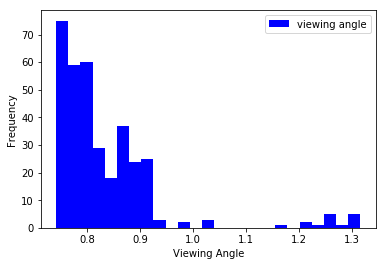

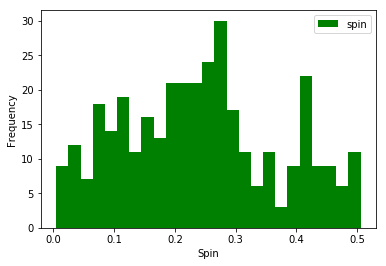

IndexError: index 2 is out of bounds for axis 0 with size 2

<Figure size 432x288 with 0 Axes>

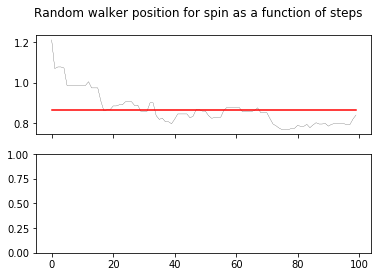

In [21]:
nburn = 50
sam = sampler.flatchain[:,:]
#print("Sampler chain is", sam)
plt.hist(sam[nburn:,0], color='b', bins=25, label='viewing angle') #ADDING the viewtruth virtical line
plt.legend(loc=0)
plt.xlabel("Viewing Angle") 
plt.ylabel("Frequency") 
plt.savefig("view.png")
plt.show()
plt.clf()

plt.hist(sam[nburn:,1], color='g', bins=25, label='spin') #ADDING the spintruth virtical line
plt.legend(loc=0)
plt.xlabel("Spin") 
plt.ylabel("Frequency") 
plt.savefig("spin.png")
plt.show()
plt.clf()

fig, ax = plt.subplots(2,1, sharex = True) #conveniently packs fig ang subplots in 1, sharex = share x axes
for i in [0,2]: #note must specify all numbers here as no range specified
    ax[i].plot(sampler.chain[0,:,i], 'k-', lw=0.2)
    ax[i].plot([0,99], [sampler.chain[0,:,i].mean(), sampler.chain[0,:,i].mean()], 'r-') #plots mean(true) in red
    plt.suptitle("Random walker position for spin as a function of steps") #puts title at top



samples = sampler.chain[:, 25:, :].reshape((-1,ndim))


#corner plot
import corner
fig = corner.corner(samples, labels=["$view$","$spin$"],
                    truths = [viewtruth, spintruth])
#fig.savefig("triange.png")




# plt.figure(4)
# for spin in samples[np.random.randint(len(samples), size = 100)]: #if high isnt specified results are from 0 - low (ie len(samples))
#     plt.plot(u+a*np.cos(tfine), v+b*np.sin(tfine), "b", lw=2, alpha = 0.3)
# plt.plot(u+a_true*np.cos(tfine), v+b_true*np.sin(tfine), "r", lw = 2, alpha = 0.8)
# plt.errorbar(x, y , yerr, fmt=".k", capsize = 1, lw=0.5)
# plt.title("Results plotted over observed data points")
